In [ ]:
import kagglehub
jp797498e_twitter_entity_sentiment_analysis_path = kagglehub.dataset_download('jp797498e/twitter-entity-sentiment-analysis')

print('Data source import complete.')


In [ ]:
!pip install transformers datasets accelerate -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 5.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.1 MB/s eta 0:00:00:00:0100:01
ERROR: pip's de

In [ ]:

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm.auto import tqdm
import os

print("PyTorch Version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device Name:", torch.cuda.get_device_name(0))



os.makedirs("./sentiment_model", exist_ok=True)


PyTorch Version: 2.6.0+cu124
CUDA available: True
Device Name: Tesla T4


In [ ]:
class Config:
    MODEL_NAME = 'prajjwal1/bert-tiny'
    DATA_PATH = '/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv'
    SAVE_PATH = './sentiment_model'

    MAX_LEN = 128

    EPOCHS = 100
    BATCH_SIZE = 64
    LEARNING_RATE = 1e-5 

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()



In [ ]:


print("\n--- Loading and Preparing Data ---")
df = pd.read_csv(config.DATA_PATH, header=None)
df.columns = ['id', 'entity', 'label', 'text']

print(f"Original data shape: {df.shape}")
print("Original label distribution:\n", df['label'].value_counts())

df = df[df['label'] != 'Irrelevant']
print(f"\nShape after removing 'Irrelevant' rows: {df.shape}")

label_map = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
df['label'] = df['label'].map(label_map)

df.dropna(subset=['text'], inplace=True)
df = df.reset_index(drop=True)

print("\nFinal label distribution:\n", df['label'].value_counts())
print("\nSample of preprocessed data:")
print(df.head())

train_df, val_df = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    stratify=df['label'] # Ensures label distribution is consistent across splits
)

print(f"\nTraining set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")



--- Loading and Preparing Data ---
Original data shape: (74682, 4)
Original label distribution:
 label
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

Shape after removing 'Irrelevant' rows: (61692, 4)

Final label distribution:
 label
0    22358
2    20655
1    18108
Name: count, dtype: int64

Sample of preprocessed data:
     id       entity  label                                               text
0  2401  Borderlands      2  im getting on borderlands and i will murder yo...
1  2401  Borderlands      2  I am coming to the borders and I will kill you...
2  2401  Borderlands      2  im getting on borderlands and i will kill you ...
3  2401  Borderlands      2  im coming on borderlands and i will murder you...
4  2401  Borderlands      2  im getting on borderlands 2 and i will murder ...

Training set size: 51952
Validation set size: 9169


In [ ]:

print("\n--- Initializing Tokenizer and Datasets ---")
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)

class SentimentClassificationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = dataframe.text.tolist()
        self.labels = dataframe.label.tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = SentimentClassificationDataset(train_df, tokenizer, config.MAX_LEN)
val_dataset = SentimentClassificationDataset(val_df, tokenizer, config.MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)
print("DataLoader setup complete.")




--- Initializing Tokenizer and Datasets ---
DataLoader setup complete.


In [ ]:

print("\n--- Initializing Model ---")
model = AutoModelForSequenceClassification.from_pretrained(config.MODEL_NAME, num_labels=3)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model)

model.to(config.DEVICE)

optimizer = AdamW(model.parameters(), lr=config.LEARNING_RATE)

loss_fn = torch.nn.CrossEntropyLoss().to(config.DEVICE)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Initializing Model ---
Using 2 GPUs!


In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        if isinstance(model, torch.nn.DataParallel): loss = loss.mean()
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    return total_loss / len(data_loader)

def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            if isinstance(model, torch.nn.DataParallel): loss = loss.mean()
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    report_str = classification_report(all_labels, all_preds, target_names=['Negative', 'Neutral', 'Positive'], zero_division=0)


    report_dict = classification_report(all_labels, all_preds, zero_division=0, output_dict=True)
    weighted_f1 = report_dict['weighted avg']['f1-score']

    return total_loss / len(data_loader), accuracy, report_str, weighted_f1



In [ ]:
import os
import warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:

print("\n--- Starting Model Training ---")
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'val_f1': []}
best_accuracy = 0

for epoch in range(config.EPOCHS):
    print(f'\n--- Epoch {epoch + 1}/{config.EPOCHS} ---')

    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, config.DEVICE)
    print(f'Training Loss: {train_loss:.4f}')



    val_loss, val_acc, val_report_str, val_weighted_f1 = eval_model(model, val_loader, loss_fn, config.DEVICE)

    print(f'Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}')
    print("Classification Report:\n", val_report_str)


    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    history['val_f1'].append(val_weighted_f1)

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        model_to_save = model.module if isinstance(model, torch.nn.DataParallel) else model
        model_to_save.save_pretrained(config.SAVE_PATH)
        tokenizer.save_pretrained(config.SAVE_PATH)
        print(f"\nNew best model saved to {config.SAVE_PATH} with accuracy: {best_accuracy:.4f}")

print("\n--- Training Complete ---")
print(f"Best validation accuracy achieved: {best_accuracy:.4f}")




--- Starting Model Training ---

--- Epoch 1/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 1.0437


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.9480 | Validation Accuracy: 0.5891
Classification Report:
               precision    recall  f1-score   support

    Negative       0.62      0.65      0.64      3354
     Neutral       0.59      0.46      0.52      2716
    Positive       0.56      0.63      0.59      3099

    accuracy                           0.59      9169
   macro avg       0.59      0.58      0.58      9169
weighted avg       0.59      0.59      0.59      9169


New best model saved to ./sentiment_model with accuracy: 0.5891

--- Epoch 2/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.8943


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.8236 | Validation Accuracy: 0.6501
Classification Report:
               precision    recall  f1-score   support

    Negative       0.66      0.77      0.71      3354
     Neutral       0.67      0.45      0.54      2716
    Positive       0.63      0.70      0.66      3099

    accuracy                           0.65      9169
   macro avg       0.65      0.64      0.64      9169
weighted avg       0.65      0.65      0.64      9169


New best model saved to ./sentiment_model with accuracy: 0.6501

--- Epoch 3/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.8145


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.7800 | Validation Accuracy: 0.6695
Classification Report:
               precision    recall  f1-score   support

    Negative       0.68      0.78      0.73      3354
     Neutral       0.68      0.49      0.57      2716
    Positive       0.65      0.71      0.68      3099

    accuracy                           0.67      9169
   macro avg       0.67      0.66      0.66      9169
weighted avg       0.67      0.67      0.66      9169


New best model saved to ./sentiment_model with accuracy: 0.6695

--- Epoch 4/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.7739


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.7459 | Validation Accuracy: 0.6905
Classification Report:
               precision    recall  f1-score   support

    Negative       0.69      0.81      0.75      3354
     Neutral       0.71      0.51      0.59      2716
    Positive       0.68      0.72      0.70      3099

    accuracy                           0.69      9169
   macro avg       0.69      0.68      0.68      9169
weighted avg       0.69      0.69      0.68      9169


New best model saved to ./sentiment_model with accuracy: 0.6905

--- Epoch 5/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.7427


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.7157 | Validation Accuracy: 0.7055
Classification Report:
               precision    recall  f1-score   support

    Negative       0.71      0.80      0.76      3354
     Neutral       0.72      0.55      0.62      2716
    Positive       0.69      0.73      0.71      3099

    accuracy                           0.71      9169
   macro avg       0.71      0.70      0.70      9169
weighted avg       0.71      0.71      0.70      9169


New best model saved to ./sentiment_model with accuracy: 0.7055

--- Epoch 6/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.7118


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.6878 | Validation Accuracy: 0.7171
Classification Report:
               precision    recall  f1-score   support

    Negative       0.72      0.81      0.77      3354
     Neutral       0.74      0.56      0.64      2716
    Positive       0.69      0.75      0.72      3099

    accuracy                           0.72      9169
   macro avg       0.72      0.71      0.71      9169
weighted avg       0.72      0.72      0.71      9169


New best model saved to ./sentiment_model with accuracy: 0.7171

--- Epoch 7/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.6858


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.6649 | Validation Accuracy: 0.7295
Classification Report:
               precision    recall  f1-score   support

    Negative       0.74      0.82      0.78      3354
     Neutral       0.71      0.63      0.67      2716
    Positive       0.73      0.72      0.72      3099

    accuracy                           0.73      9169
   macro avg       0.73      0.72      0.72      9169
weighted avg       0.73      0.73      0.73      9169


New best model saved to ./sentiment_model with accuracy: 0.7295

--- Epoch 8/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.6598


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.6366 | Validation Accuracy: 0.7412
Classification Report:
               precision    recall  f1-score   support

    Negative       0.78      0.80      0.79      3354
     Neutral       0.71      0.65      0.68      2716
    Positive       0.72      0.76      0.74      3099

    accuracy                           0.74      9169
   macro avg       0.74      0.74      0.74      9169
weighted avg       0.74      0.74      0.74      9169


New best model saved to ./sentiment_model with accuracy: 0.7412

--- Epoch 9/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.6333


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.6123 | Validation Accuracy: 0.7545
Classification Report:
               precision    recall  f1-score   support

    Negative       0.79      0.82      0.80      3354
     Neutral       0.74      0.66      0.70      2716
    Positive       0.73      0.77      0.75      3099

    accuracy                           0.75      9169
   macro avg       0.75      0.75      0.75      9169
weighted avg       0.75      0.75      0.75      9169


New best model saved to ./sentiment_model with accuracy: 0.7545

--- Epoch 10/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.6084


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.5902 | Validation Accuracy: 0.7631
Classification Report:
               precision    recall  f1-score   support

    Negative       0.80      0.82      0.81      3354
     Neutral       0.76      0.66      0.70      2716
    Positive       0.73      0.79      0.76      3099

    accuracy                           0.76      9169
   macro avg       0.76      0.76      0.76      9169
weighted avg       0.76      0.76      0.76      9169


New best model saved to ./sentiment_model with accuracy: 0.7631

--- Epoch 11/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.5807


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.5704 | Validation Accuracy: 0.7742
Classification Report:
               precision    recall  f1-score   support

    Negative       0.83      0.82      0.82      3354
     Neutral       0.72      0.74      0.73      2716
    Positive       0.77      0.76      0.76      3099

    accuracy                           0.77      9169
   macro avg       0.77      0.77      0.77      9169
weighted avg       0.77      0.77      0.77      9169


New best model saved to ./sentiment_model with accuracy: 0.7742

--- Epoch 12/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.5573


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.5419 | Validation Accuracy: 0.7849
Classification Report:
               precision    recall  f1-score   support

    Negative       0.82      0.84      0.83      3354
     Neutral       0.77      0.70      0.74      2716
    Positive       0.76      0.80      0.78      3099

    accuracy                           0.78      9169
   macro avg       0.78      0.78      0.78      9169
weighted avg       0.78      0.78      0.78      9169


New best model saved to ./sentiment_model with accuracy: 0.7849

--- Epoch 13/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.5333


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.5226 | Validation Accuracy: 0.7938
Classification Report:
               precision    recall  f1-score   support

    Negative       0.83      0.84      0.83      3354
     Neutral       0.78      0.72      0.75      2716
    Positive       0.77      0.81      0.79      3099

    accuracy                           0.79      9169
   macro avg       0.79      0.79      0.79      9169
weighted avg       0.79      0.79      0.79      9169


New best model saved to ./sentiment_model with accuracy: 0.7938

--- Epoch 14/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.5107


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.5056 | Validation Accuracy: 0.8031
Classification Report:
               precision    recall  f1-score   support

    Negative       0.82      0.86      0.84      3354
     Neutral       0.78      0.75      0.76      2716
    Positive       0.80      0.79      0.80      3099

    accuracy                           0.80      9169
   macro avg       0.80      0.80      0.80      9169
weighted avg       0.80      0.80      0.80      9169


New best model saved to ./sentiment_model with accuracy: 0.8031

--- Epoch 15/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.4901


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.4873 | Validation Accuracy: 0.8109
Classification Report:
               precision    recall  f1-score   support

    Negative       0.84      0.85      0.85      3354
     Neutral       0.78      0.77      0.78      2716
    Positive       0.80      0.81      0.80      3099

    accuracy                           0.81      9169
   macro avg       0.81      0.81      0.81      9169
weighted avg       0.81      0.81      0.81      9169


New best model saved to ./sentiment_model with accuracy: 0.8109

--- Epoch 16/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.4656


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.4797 | Validation Accuracy: 0.8139
Classification Report:
               precision    recall  f1-score   support

    Negative       0.87      0.82      0.85      3354
     Neutral       0.77      0.80      0.78      2716
    Positive       0.80      0.82      0.81      3099

    accuracy                           0.81      9169
   macro avg       0.81      0.81      0.81      9169
weighted avg       0.82      0.81      0.81      9169


New best model saved to ./sentiment_model with accuracy: 0.8139

--- Epoch 17/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.4524


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.4579 | Validation Accuracy: 0.8241
Classification Report:
               precision    recall  f1-score   support

    Negative       0.86      0.85      0.86      3354
     Neutral       0.81      0.78      0.80      2716
    Positive       0.79      0.84      0.81      3099

    accuracy                           0.82      9169
   macro avg       0.82      0.82      0.82      9169
weighted avg       0.82      0.82      0.82      9169


New best model saved to ./sentiment_model with accuracy: 0.8241

--- Epoch 18/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.4300


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.4437 | Validation Accuracy: 0.8312
Classification Report:
               precision    recall  f1-score   support

    Negative       0.86      0.86      0.86      3354
     Neutral       0.81      0.80      0.80      2716
    Positive       0.82      0.83      0.82      3099

    accuracy                           0.83      9169
   macro avg       0.83      0.83      0.83      9169
weighted avg       0.83      0.83      0.83      9169


New best model saved to ./sentiment_model with accuracy: 0.8312

--- Epoch 19/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.4129


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.4325 | Validation Accuracy: 0.8379
Classification Report:
               precision    recall  f1-score   support

    Negative       0.86      0.87      0.87      3354
     Neutral       0.81      0.81      0.81      2716
    Positive       0.84      0.82      0.83      3099

    accuracy                           0.84      9169
   macro avg       0.84      0.84      0.84      9169
weighted avg       0.84      0.84      0.84      9169


New best model saved to ./sentiment_model with accuracy: 0.8379

--- Epoch 20/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.3997


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.4153 | Validation Accuracy: 0.8455
Classification Report:
               precision    recall  f1-score   support

    Negative       0.88      0.87      0.87      3354
     Neutral       0.82      0.82      0.82      2716
    Positive       0.84      0.84      0.84      3099

    accuracy                           0.85      9169
   macro avg       0.84      0.84      0.84      9169
weighted avg       0.85      0.85      0.85      9169


New best model saved to ./sentiment_model with accuracy: 0.8455

--- Epoch 21/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.3866


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.4046 | Validation Accuracy: 0.8495
Classification Report:
               precision    recall  f1-score   support

    Negative       0.88      0.88      0.88      3354
     Neutral       0.83      0.82      0.82      2716
    Positive       0.84      0.85      0.84      3099

    accuracy                           0.85      9169
   macro avg       0.85      0.85      0.85      9169
weighted avg       0.85      0.85      0.85      9169


New best model saved to ./sentiment_model with accuracy: 0.8495

--- Epoch 22/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.3687


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3983 | Validation Accuracy: 0.8519
Classification Report:
               precision    recall  f1-score   support

    Negative       0.89      0.87      0.88      3354
     Neutral       0.83      0.83      0.83      2716
    Positive       0.83      0.85      0.84      3099

    accuracy                           0.85      9169
   macro avg       0.85      0.85      0.85      9169
weighted avg       0.85      0.85      0.85      9169


New best model saved to ./sentiment_model with accuracy: 0.8519

--- Epoch 23/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.3555


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3899 | Validation Accuracy: 0.8571
Classification Report:
               precision    recall  f1-score   support

    Negative       0.89      0.88      0.89      3354
     Neutral       0.82      0.85      0.83      2716
    Positive       0.86      0.84      0.85      3099

    accuracy                           0.86      9169
   macro avg       0.86      0.86      0.86      9169
weighted avg       0.86      0.86      0.86      9169


New best model saved to ./sentiment_model with accuracy: 0.8571

--- Epoch 24/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.3439


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3754 | Validation Accuracy: 0.8607
Classification Report:
               precision    recall  f1-score   support

    Negative       0.89      0.88      0.88      3354
     Neutral       0.84      0.84      0.84      2716
    Positive       0.85      0.86      0.85      3099

    accuracy                           0.86      9169
   macro avg       0.86      0.86      0.86      9169
weighted avg       0.86      0.86      0.86      9169


New best model saved to ./sentiment_model with accuracy: 0.8607

--- Epoch 25/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.3294


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3688 | Validation Accuracy: 0.8649
Classification Report:
               precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      3354
     Neutral       0.85      0.84      0.84      2716
    Positive       0.84      0.88      0.86      3099

    accuracy                           0.86      9169
   macro avg       0.86      0.86      0.86      9169
weighted avg       0.87      0.86      0.86      9169


New best model saved to ./sentiment_model with accuracy: 0.8649

--- Epoch 26/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.3201


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3603 | Validation Accuracy: 0.8702
Classification Report:
               precision    recall  f1-score   support

    Negative       0.90      0.89      0.89      3354
     Neutral       0.85      0.85      0.85      2716
    Positive       0.86      0.86      0.86      3099

    accuracy                           0.87      9169
   macro avg       0.87      0.87      0.87      9169
weighted avg       0.87      0.87      0.87      9169


New best model saved to ./sentiment_model with accuracy: 0.8702

--- Epoch 27/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.3126


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3498 | Validation Accuracy: 0.8725
Classification Report:
               precision    recall  f1-score   support

    Negative       0.89      0.89      0.89      3354
     Neutral       0.86      0.85      0.86      2716
    Positive       0.86      0.87      0.87      3099

    accuracy                           0.87      9169
   macro avg       0.87      0.87      0.87      9169
weighted avg       0.87      0.87      0.87      9169


New best model saved to ./sentiment_model with accuracy: 0.8725

--- Epoch 28/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.3007


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3451 | Validation Accuracy: 0.8743
Classification Report:
               precision    recall  f1-score   support

    Negative       0.89      0.90      0.89      3354
     Neutral       0.86      0.85      0.86      2716
    Positive       0.87      0.87      0.87      3099

    accuracy                           0.87      9169
   macro avg       0.87      0.87      0.87      9169
weighted avg       0.87      0.87      0.87      9169


New best model saved to ./sentiment_model with accuracy: 0.8743

--- Epoch 29/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.2897


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3385 | Validation Accuracy: 0.8773
Classification Report:
               precision    recall  f1-score   support

    Negative       0.90      0.89      0.90      3354
     Neutral       0.86      0.86      0.86      2716
    Positive       0.87      0.87      0.87      3099

    accuracy                           0.88      9169
   macro avg       0.88      0.88      0.88      9169
weighted avg       0.88      0.88      0.88      9169


New best model saved to ./sentiment_model with accuracy: 0.8773

--- Epoch 30/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.2803


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3364 | Validation Accuracy: 0.8772
Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.88      0.89      3354
     Neutral       0.85      0.87      0.86      2716
    Positive       0.86      0.89      0.87      3099

    accuracy                           0.88      9169
   macro avg       0.88      0.88      0.88      9169
weighted avg       0.88      0.88      0.88      9169


--- Epoch 31/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.2744


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3302 | Validation Accuracy: 0.8809
Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.88      0.90      3354
     Neutral       0.85      0.88      0.87      2716
    Positive       0.88      0.88      0.88      3099

    accuracy                           0.88      9169
   macro avg       0.88      0.88      0.88      9169
weighted avg       0.88      0.88      0.88      9169


New best model saved to ./sentiment_model with accuracy: 0.8809

--- Epoch 32/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.2663


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3258 | Validation Accuracy: 0.8847
Classification Report:
               precision    recall  f1-score   support

    Negative       0.90      0.90      0.90      3354
     Neutral       0.85      0.89      0.87      2716
    Positive       0.89      0.86      0.88      3099

    accuracy                           0.88      9169
   macro avg       0.88      0.88      0.88      9169
weighted avg       0.89      0.88      0.88      9169


New best model saved to ./sentiment_model with accuracy: 0.8847

--- Epoch 33/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.2574


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3250 | Validation Accuracy: 0.8855
Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.89      0.90      3354
     Neutral       0.86      0.89      0.87      2716
    Positive       0.88      0.88      0.88      3099

    accuracy                           0.89      9169
   macro avg       0.88      0.89      0.88      9169
weighted avg       0.89      0.89      0.89      9169


New best model saved to ./sentiment_model with accuracy: 0.8855

--- Epoch 34/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.2506


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3166 | Validation Accuracy: 0.8889
Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.89      0.90      3354
     Neutral       0.87      0.88      0.88      2716
    Positive       0.88      0.89      0.89      3099

    accuracy                           0.89      9169
   macro avg       0.89      0.89      0.89      9169
weighted avg       0.89      0.89      0.89      9169


New best model saved to ./sentiment_model with accuracy: 0.8889

--- Epoch 35/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.2425


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3129 | Validation Accuracy: 0.8888
Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.90      0.90      3354
     Neutral       0.86      0.89      0.88      2716
    Positive       0.89      0.88      0.88      3099

    accuracy                           0.89      9169
   macro avg       0.89      0.89      0.89      9169
weighted avg       0.89      0.89      0.89      9169


--- Epoch 36/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.2386


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3147 | Validation Accuracy: 0.8910
Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.90      0.91      3354
     Neutral       0.87      0.89      0.88      2716
    Positive       0.89      0.88      0.89      3099

    accuracy                           0.89      9169
   macro avg       0.89      0.89      0.89      9169
weighted avg       0.89      0.89      0.89      9169


New best model saved to ./sentiment_model with accuracy: 0.8910

--- Epoch 37/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.2303


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3084 | Validation Accuracy: 0.8919
Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.89      0.91      3354
     Neutral       0.87      0.89      0.88      2716
    Positive       0.89      0.89      0.89      3099

    accuracy                           0.89      9169
   macro avg       0.89      0.89      0.89      9169
weighted avg       0.89      0.89      0.89      9169


New best model saved to ./sentiment_model with accuracy: 0.8919

--- Epoch 38/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.2238


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3044 | Validation Accuracy: 0.8957
Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.91      0.91      3354
     Neutral       0.88      0.89      0.88      2716
    Positive       0.89      0.89      0.89      3099

    accuracy                           0.90      9169
   macro avg       0.89      0.90      0.89      9169
weighted avg       0.90      0.90      0.90      9169


New best model saved to ./sentiment_model with accuracy: 0.8957

--- Epoch 39/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.2212


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3048 | Validation Accuracy: 0.8944
Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.90      0.91      3354
     Neutral       0.88      0.89      0.88      2716
    Positive       0.89      0.89      0.89      3099

    accuracy                           0.89      9169
   macro avg       0.89      0.89      0.89      9169
weighted avg       0.89      0.89      0.89      9169


--- Epoch 40/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.2132


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3008 | Validation Accuracy: 0.8966
Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.91      0.91      3354
     Neutral       0.86      0.91      0.89      2716
    Positive       0.92      0.88      0.90      3099

    accuracy                           0.90      9169
   macro avg       0.90      0.90      0.90      9169
weighted avg       0.90      0.90      0.90      9169


New best model saved to ./sentiment_model with accuracy: 0.8966

--- Epoch 41/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.2097


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2998 | Validation Accuracy: 0.8954
Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.90      0.91      3354
     Neutral       0.86      0.91      0.88      2716
    Positive       0.91      0.88      0.89      3099

    accuracy                           0.90      9169
   macro avg       0.89      0.90      0.89      9169
weighted avg       0.90      0.90      0.90      9169


--- Epoch 42/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.2041


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2949 | Validation Accuracy: 0.8964
Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.91      0.91      3354
     Neutral       0.88      0.89      0.89      2716
    Positive       0.90      0.89      0.89      3099

    accuracy                           0.90      9169
   macro avg       0.90      0.90      0.90      9169
weighted avg       0.90      0.90      0.90      9169


--- Epoch 43/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1986


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2946 | Validation Accuracy: 0.9025
Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.92      0.92      3354
     Neutral       0.88      0.90      0.89      2716
    Positive       0.91      0.89      0.90      3099

    accuracy                           0.90      9169
   macro avg       0.90      0.90      0.90      9169
weighted avg       0.90      0.90      0.90      9169


New best model saved to ./sentiment_model with accuracy: 0.9025

--- Epoch 44/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1937


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2906 | Validation Accuracy: 0.9029
Classification Report:
               precision    recall  f1-score   support

    Negative       0.90      0.92      0.91      3354
     Neutral       0.88      0.90      0.89      2716
    Positive       0.92      0.88      0.90      3099

    accuracy                           0.90      9169
   macro avg       0.90      0.90      0.90      9169
weighted avg       0.90      0.90      0.90      9169


New best model saved to ./sentiment_model with accuracy: 0.9029

--- Epoch 45/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1871


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2901 | Validation Accuracy: 0.9037
Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.92      0.92      3354
     Neutral       0.87      0.91      0.89      2716
    Positive       0.92      0.88      0.90      3099

    accuracy                           0.90      9169
   macro avg       0.90      0.90      0.90      9169
weighted avg       0.90      0.90      0.90      9169


New best model saved to ./sentiment_model with accuracy: 0.9037

--- Epoch 46/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1862


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2937 | Validation Accuracy: 0.9035
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.90      0.92      3354
     Neutral       0.88      0.91      0.89      2716
    Positive       0.90      0.90      0.90      3099

    accuracy                           0.90      9169
   macro avg       0.90      0.90      0.90      9169
weighted avg       0.90      0.90      0.90      9169


--- Epoch 47/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1806


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2924 | Validation Accuracy: 0.9053
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.91      0.92      3354
     Neutral       0.88      0.91      0.89      2716
    Positive       0.91      0.89      0.90      3099

    accuracy                           0.91      9169
   macro avg       0.90      0.91      0.90      9169
weighted avg       0.91      0.91      0.91      9169


New best model saved to ./sentiment_model with accuracy: 0.9053

--- Epoch 48/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1783


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2892 | Validation Accuracy: 0.9049
Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.91      0.92      3354
     Neutral       0.88      0.91      0.89      2716
    Positive       0.92      0.89      0.90      3099

    accuracy                           0.90      9169
   macro avg       0.90      0.90      0.90      9169
weighted avg       0.91      0.90      0.90      9169


--- Epoch 49/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1760


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2929 | Validation Accuracy: 0.9054
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.90      0.92      3354
     Neutral       0.88      0.92      0.90      2716
    Positive       0.91      0.90      0.90      3099

    accuracy                           0.91      9169
   macro avg       0.90      0.91      0.90      9169
weighted avg       0.91      0.91      0.91      9169


New best model saved to ./sentiment_model with accuracy: 0.9054

--- Epoch 50/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1698


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2961 | Validation Accuracy: 0.9051
Classification Report:
               precision    recall  f1-score   support

    Negative       0.94      0.90      0.92      3354
     Neutral       0.87      0.92      0.90      2716
    Positive       0.90      0.90      0.90      3099

    accuracy                           0.91      9169
   macro avg       0.90      0.91      0.90      9169
weighted avg       0.91      0.91      0.91      9169


--- Epoch 51/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1672


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2898 | Validation Accuracy: 0.9078
Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.92      0.92      3354
     Neutral       0.89      0.91      0.90      2716
    Positive       0.92      0.89      0.90      3099

    accuracy                           0.91      9169
   macro avg       0.91      0.91      0.91      9169
weighted avg       0.91      0.91      0.91      9169


New best model saved to ./sentiment_model with accuracy: 0.9078

--- Epoch 52/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1639


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2918 | Validation Accuracy: 0.9084
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.91      0.92      3354
     Neutral       0.87      0.92      0.90      2716
    Positive       0.92      0.90      0.91      3099

    accuracy                           0.91      9169
   macro avg       0.91      0.91      0.91      9169
weighted avg       0.91      0.91      0.91      9169


New best model saved to ./sentiment_model with accuracy: 0.9084

--- Epoch 53/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1590


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2881 | Validation Accuracy: 0.9105
Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.92      0.92      3354
     Neutral       0.89      0.92      0.90      2716
    Positive       0.92      0.90      0.91      3099

    accuracy                           0.91      9169
   macro avg       0.91      0.91      0.91      9169
weighted avg       0.91      0.91      0.91      9169


New best model saved to ./sentiment_model with accuracy: 0.9105

--- Epoch 54/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1582


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2926 | Validation Accuracy: 0.9100
Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.92      0.92      3354
     Neutral       0.87      0.93      0.90      2716
    Positive       0.94      0.88      0.91      3099

    accuracy                           0.91      9169
   macro avg       0.91      0.91      0.91      9169
weighted avg       0.91      0.91      0.91      9169


--- Epoch 55/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1537


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2874 | Validation Accuracy: 0.9100
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.91      0.92      3354
     Neutral       0.88      0.92      0.90      2716
    Positive       0.92      0.90      0.91      3099

    accuracy                           0.91      9169
   macro avg       0.91      0.91      0.91      9169
weighted avg       0.91      0.91      0.91      9169


--- Epoch 56/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1496


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2895 | Validation Accuracy: 0.9111
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.91      0.92      3354
     Neutral       0.89      0.92      0.90      2716
    Positive       0.92      0.90      0.91      3099

    accuracy                           0.91      9169
   macro avg       0.91      0.91      0.91      9169
weighted avg       0.91      0.91      0.91      9169


New best model saved to ./sentiment_model with accuracy: 0.9111

--- Epoch 57/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1470


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2840 | Validation Accuracy: 0.9136
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.91      0.92      3354
     Neutral       0.90      0.92      0.91      2716
    Positive       0.91      0.91      0.91      3099

    accuracy                           0.91      9169
   macro avg       0.91      0.91      0.91      9169
weighted avg       0.91      0.91      0.91      9169


New best model saved to ./sentiment_model with accuracy: 0.9136

--- Epoch 58/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1432


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2902 | Validation Accuracy: 0.9105
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.91      0.92      3354
     Neutral       0.87      0.94      0.90      2716
    Positive       0.93      0.89      0.91      3099

    accuracy                           0.91      9169
   macro avg       0.91      0.91      0.91      9169
weighted avg       0.91      0.91      0.91      9169


--- Epoch 59/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1404


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2937 | Validation Accuracy: 0.9124
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.92      0.92      3354
     Neutral       0.88      0.93      0.90      2716
    Positive       0.92      0.90      0.91      3099

    accuracy                           0.91      9169
   macro avg       0.91      0.91      0.91      9169
weighted avg       0.91      0.91      0.91      9169


--- Epoch 60/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1381


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2874 | Validation Accuracy: 0.9142
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.92      0.92      3354
     Neutral       0.90      0.91      0.91      2716
    Positive       0.91      0.91      0.91      3099

    accuracy                           0.91      9169
   macro avg       0.91      0.91      0.91      9169
weighted avg       0.91      0.91      0.91      9169


New best model saved to ./sentiment_model with accuracy: 0.9142

--- Epoch 61/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1349


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2903 | Validation Accuracy: 0.9136
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.92      0.92      3354
     Neutral       0.88      0.93      0.91      2716
    Positive       0.93      0.90      0.91      3099

    accuracy                           0.91      9169
   macro avg       0.91      0.91      0.91      9169
weighted avg       0.91      0.91      0.91      9169


--- Epoch 62/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1343


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2951 | Validation Accuracy: 0.9119
Classification Report:
               precision    recall  f1-score   support

    Negative       0.94      0.90      0.92      3354
     Neutral       0.89      0.93      0.91      2716
    Positive       0.91      0.91      0.91      3099

    accuracy                           0.91      9169
   macro avg       0.91      0.91      0.91      9169
weighted avg       0.91      0.91      0.91      9169


--- Epoch 63/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1338


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2875 | Validation Accuracy: 0.9150
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.92      0.92      3354
     Neutral       0.90      0.92      0.91      2716
    Positive       0.92      0.90      0.91      3099

    accuracy                           0.92      9169
   macro avg       0.91      0.91      0.91      9169
weighted avg       0.92      0.92      0.92      9169


New best model saved to ./sentiment_model with accuracy: 0.9150

--- Epoch 64/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1308


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2895 | Validation Accuracy: 0.9138
Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.93      0.92      3354
     Neutral       0.90      0.91      0.91      2716
    Positive       0.92      0.90      0.91      3099

    accuracy                           0.91      9169
   macro avg       0.91      0.91      0.91      9169
weighted avg       0.91      0.91      0.91      9169


--- Epoch 65/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1285


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2945 | Validation Accuracy: 0.9146
Classification Report:
               precision    recall  f1-score   support

    Negative       0.94      0.91      0.92      3354
     Neutral       0.89      0.93      0.91      2716
    Positive       0.91      0.91      0.91      3099

    accuracy                           0.91      9169
   macro avg       0.91      0.92      0.91      9169
weighted avg       0.92      0.91      0.91      9169


--- Epoch 66/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1255


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2955 | Validation Accuracy: 0.9160
Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.93      0.92      3354
     Neutral       0.90      0.92      0.91      2716
    Positive       0.93      0.90      0.91      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


New best model saved to ./sentiment_model with accuracy: 0.9160

--- Epoch 67/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1260


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2931 | Validation Accuracy: 0.9150
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.92      0.93      3354
     Neutral       0.90      0.91      0.91      2716
    Positive       0.90      0.91      0.91      3099

    accuracy                           0.92      9169
   macro avg       0.91      0.91      0.91      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 68/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1226


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2920 | Validation Accuracy: 0.9161
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.92      0.92      3354
     Neutral       0.90      0.92      0.91      2716
    Positive       0.91      0.91      0.91      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


New best model saved to ./sentiment_model with accuracy: 0.9161

--- Epoch 69/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1176


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2949 | Validation Accuracy: 0.9180
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.92      0.93      3354
     Neutral       0.90      0.93      0.91      2716
    Positive       0.92      0.91      0.91      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


New best model saved to ./sentiment_model with accuracy: 0.9180

--- Epoch 70/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1199


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3023 | Validation Accuracy: 0.9154
Classification Report:
               precision    recall  f1-score   support

    Negative       0.94      0.91      0.92      3354
     Neutral       0.88      0.93      0.91      2716
    Positive       0.92      0.91      0.91      3099

    accuracy                           0.92      9169
   macro avg       0.91      0.92      0.91      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 71/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1155


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2939 | Validation Accuracy: 0.9171
Classification Report:
               precision    recall  f1-score   support

    Negative       0.94      0.92      0.93      3354
     Neutral       0.90      0.92      0.91      2716
    Positive       0.91      0.91      0.91      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 72/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1166


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2959 | Validation Accuracy: 0.9175
Classification Report:
               precision    recall  f1-score   support

    Negative       0.94      0.92      0.93      3354
     Neutral       0.89      0.93      0.91      2716
    Positive       0.92      0.91      0.91      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 73/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1135


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2922 | Validation Accuracy: 0.9175
Classification Report:
               precision    recall  f1-score   support

    Negative       0.94      0.91      0.93      3354
     Neutral       0.90      0.93      0.91      2716
    Positive       0.91      0.92      0.91      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 74/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1101


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2946 | Validation Accuracy: 0.9201
Classification Report:
               precision    recall  f1-score   support

    Negative       0.94      0.91      0.93      3354
     Neutral       0.90      0.93      0.91      2716
    Positive       0.91      0.92      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


New best model saved to ./sentiment_model with accuracy: 0.9201

--- Epoch 75/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1073


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2975 | Validation Accuracy: 0.9196
Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.93      0.92      3354
     Neutral       0.91      0.93      0.92      2716
    Positive       0.93      0.90      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 76/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1099


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.2977 | Validation Accuracy: 0.9199
Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.93      0.92      3354
     Neutral       0.92      0.92      0.92      2716
    Positive       0.92      0.91      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 77/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1050


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3012 | Validation Accuracy: 0.9182
Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.92      0.92      3354
     Neutral       0.92      0.92      0.92      2716
    Positive       0.92      0.91      0.91      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 78/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1075


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3028 | Validation Accuracy: 0.9166
Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.92      0.92      3354
     Neutral       0.91      0.92      0.91      2716
    Positive       0.92      0.91      0.91      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 79/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1011


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3030 | Validation Accuracy: 0.9205
Classification Report:
               precision    recall  f1-score   support

    Negative       0.94      0.92      0.93      3354
     Neutral       0.90      0.93      0.91      2716
    Positive       0.92      0.91      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


New best model saved to ./sentiment_model with accuracy: 0.9205

--- Epoch 80/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.1013


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3043 | Validation Accuracy: 0.9189
Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.93      0.93      3354
     Neutral       0.91      0.92      0.91      2716
    Positive       0.93      0.91      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 81/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0993


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3062 | Validation Accuracy: 0.9209
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.93      0.93      3354
     Neutral       0.90      0.93      0.92      2716
    Positive       0.93      0.91      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


New best model saved to ./sentiment_model with accuracy: 0.9209

--- Epoch 82/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0994


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3056 | Validation Accuracy: 0.9203
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.92      0.93      3354
     Neutral       0.90      0.93      0.92      2716
    Positive       0.92      0.91      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 83/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0966


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3054 | Validation Accuracy: 0.9215
Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.93      0.93      3354
     Neutral       0.92      0.92      0.92      2716
    Positive       0.93      0.91      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


New best model saved to ./sentiment_model with accuracy: 0.9215

--- Epoch 84/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0943


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3158 | Validation Accuracy: 0.9196
Classification Report:
               precision    recall  f1-score   support

    Negative       0.95      0.91      0.93      3354
     Neutral       0.89      0.94      0.91      2716
    Positive       0.92      0.91      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 85/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0933


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3085 | Validation Accuracy: 0.9204
Classification Report:
               precision    recall  f1-score   support

    Negative       0.94      0.92      0.93      3354
     Neutral       0.90      0.93      0.91      2716
    Positive       0.92      0.92      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 86/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0947


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3097 | Validation Accuracy: 0.9195
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.93      0.93      3354
     Neutral       0.91      0.92      0.91      2716
    Positive       0.92      0.91      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 87/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0921


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3105 | Validation Accuracy: 0.9192
Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.93      0.92      3354
     Neutral       0.91      0.92      0.92      2716
    Positive       0.92      0.91      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 88/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0908


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3132 | Validation Accuracy: 0.9203
Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.93      0.93      3354
     Neutral       0.91      0.92      0.92      2716
    Positive       0.93      0.91      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 89/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0893


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3190 | Validation Accuracy: 0.9187
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.93      0.93      3354
     Neutral       0.91      0.92      0.91      2716
    Positive       0.92      0.91      0.91      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 90/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0897


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3168 | Validation Accuracy: 0.9219
Classification Report:
               precision    recall  f1-score   support

    Negative       0.94      0.92      0.93      3354
     Neutral       0.91      0.92      0.92      2716
    Positive       0.91      0.93      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


New best model saved to ./sentiment_model with accuracy: 0.9219

--- Epoch 91/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0881


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3234 | Validation Accuracy: 0.9198
Classification Report:
               precision    recall  f1-score   support

    Negative       0.95      0.91      0.93      3354
     Neutral       0.90      0.93      0.91      2716
    Positive       0.91      0.92      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 92/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0889


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3202 | Validation Accuracy: 0.9207
Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.93      0.93      3354
     Neutral       0.91      0.93      0.92      2716
    Positive       0.93      0.91      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 93/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0870


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3129 | Validation Accuracy: 0.9210
Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.94      0.92      3354
     Neutral       0.92      0.92      0.92      2716
    Positive       0.93      0.91      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 94/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0848


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3218 | Validation Accuracy: 0.9219
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.92      0.93      3354
     Neutral       0.91      0.92      0.92      2716
    Positive       0.92      0.92      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 95/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0839


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3234 | Validation Accuracy: 0.9198
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.92      0.93      3354
     Neutral       0.91      0.92      0.91      2716
    Positive       0.92      0.92      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 96/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0823


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3222 | Validation Accuracy: 0.9221
Classification Report:
               precision    recall  f1-score   support

    Negative       0.94      0.92      0.93      3354
     Neutral       0.90      0.93      0.92      2716
    Positive       0.92      0.91      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


New best model saved to ./sentiment_model with accuracy: 0.9221

--- Epoch 97/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0813


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3244 | Validation Accuracy: 0.9208
Classification Report:
               precision    recall  f1-score   support

    Negative       0.94      0.92      0.93      3354
     Neutral       0.89      0.94      0.91      2716
    Positive       0.93      0.91      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 98/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0819


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3294 | Validation Accuracy: 0.9195
Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.93      0.92      3354
     Neutral       0.91      0.92      0.92      2716
    Positive       0.92      0.91      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Epoch 99/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0811


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3253 | Validation Accuracy: 0.9222
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.93      0.93      3354
     Neutral       0.90      0.93      0.92      2716
    Positive       0.93      0.91      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


New best model saved to ./sentiment_model with accuracy: 0.9222

--- Epoch 100/100 ---


Training:   0%|          | 0/812 [00:00<?, ?it/s]

Training Loss: 0.0793


Evaluating:   0%|          | 0/144 [00:00<?, ?it/s]

Validation Loss: 0.3292 | Validation Accuracy: 0.9222
Classification Report:
               precision    recall  f1-score   support

    Negative       0.95      0.92      0.93      3354
     Neutral       0.90      0.93      0.92      2716
    Positive       0.91      0.92      0.92      3099

    accuracy                           0.92      9169
   macro avg       0.92      0.92      0.92      9169
weighted avg       0.92      0.92      0.92      9169


--- Training Complete ---
Best validation accuracy achieved: 0.9222


In [ ]:
import matplotlib.pyplot as plt


--- Plotting Training History ---


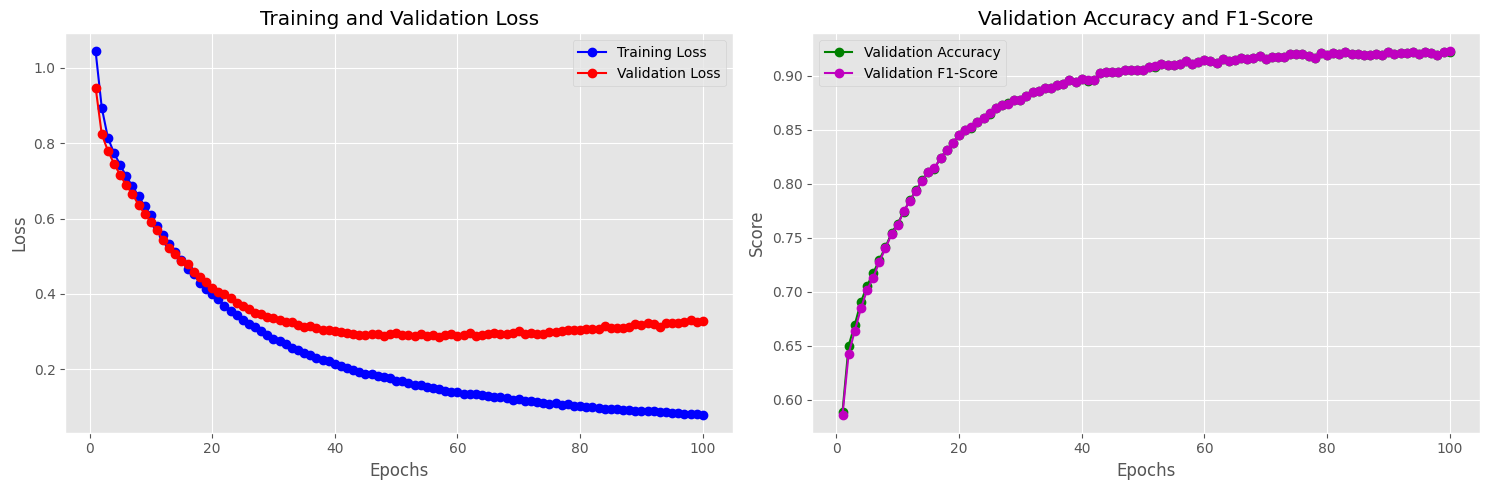

In [ ]:

print("\n--- Plotting Training History ---")

plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
epochs_range = range(1, config.EPOCHS + 1)

ax1.plot(epochs_range, history['train_loss'], 'b-o', label='Training Loss')
ax1.plot(epochs_range, history['val_loss'], 'r-o', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs_range, history['val_accuracy'], 'g-o', label='Validation Accuracy')
ax2.plot(epochs_range, history['val_f1'], 'm-o', label='Validation F1-Score')
ax2.set_title('Validation Accuracy and F1-Score')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Score')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()



In [ ]:


print("\n--- Loading saved model for inference test ---")
final_model = AutoModelForSequenceClassification.from_pretrained(config.SAVE_PATH)
final_tokenizer = AutoTokenizer.from_pretrained(config.SAVE_PATH)

final_model.to(config.DEVICE)
final_model.eval()

def predict_sentiment(text):
    inputs = final_tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=config.MAX_LEN,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = inputs['input_ids'].to(config.DEVICE)
    attention_mask = inputs['attention_mask'].to(config.DEVICE)

    with torch.no_grad():
        outputs = final_model(input_ids=input_ids, attention_mask=attention_mask)

    prediction = torch.argmax(outputs.logits, dim=1).item()
    confidence = torch.nn.functional.softmax(outputs.logits, dim=1).max().item()

    # Reverse the label map to get the sentiment string
    reverse_label_map = {v: k for k, v in label_map.items()}
    return reverse_label_map[prediction], confidence

# Test with some example sentences
test_texts = [
    "This game is absolutely fantastic, I can't stop playing!",
    "The customer service was terrible and I had to wait for hours.",
    "It's an okay product, not great but not bad either.",
]

print("\n--- Inference Examples ---")
for text in test_texts:
    sentiment, conf = predict_sentiment(text)
    print(f"Text: '{text}'\nPredicted Sentiment: {sentiment} (Confidence: {conf:.4f})\n")



--- Loading saved model for inference test ---

--- Inference Examples ---
Text: 'This game is absolutely fantastic, I can't stop playing!'
Predicted Sentiment: Positive (Confidence: 0.9996)

Text: 'The customer service was terrible and I had to wait for hours.'
Predicted Sentiment: Positive (Confidence: 0.9989)

Text: 'It's an okay product, not great but not bad either.'
Predicted Sentiment: Neutral (Confidence: 0.9960)

